Analyzing Model Performance for Concept Drift...


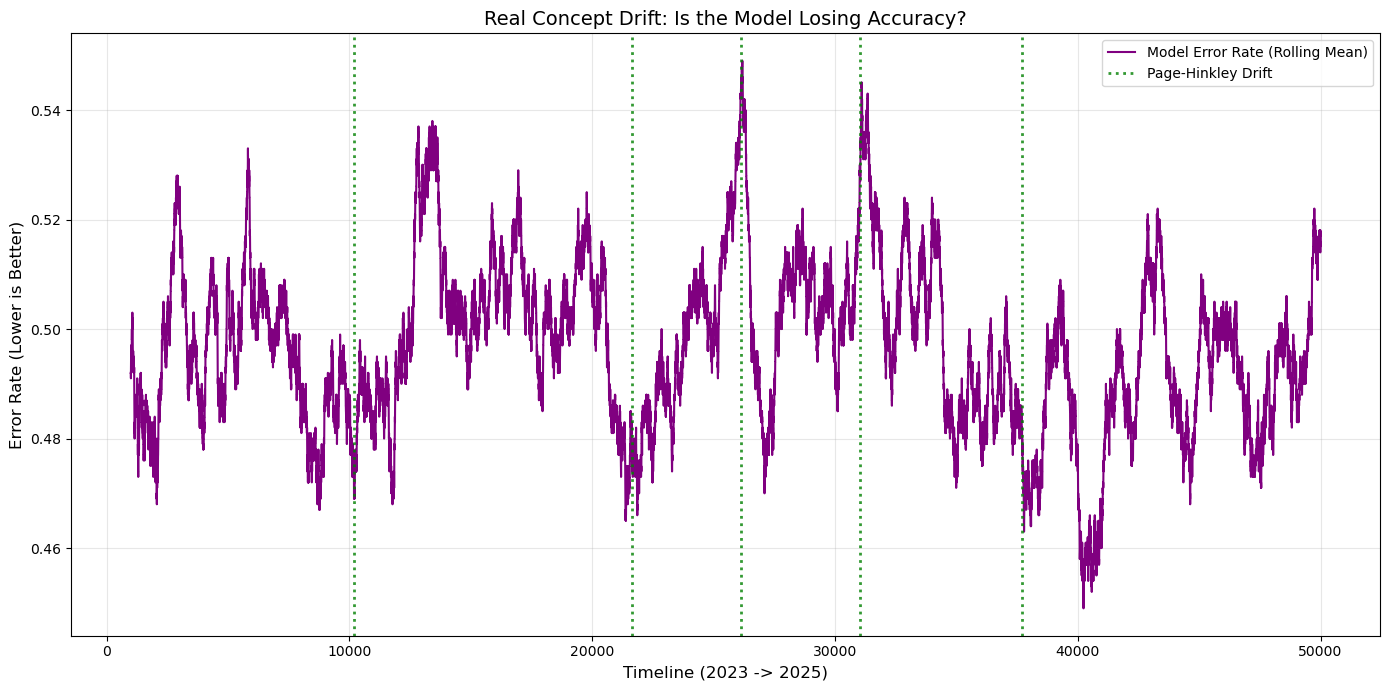

ADWIN detected 0 performance drops.
Page-Hinkley detected 5 performance drops.


In [1]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from river import drift

# 1. Prepare Data (Sorted Chronologically)
# We need the full features to generate predictions
df = pd.read_csv('click_prediction.csv')
df = df.sort_values(by=['year', 'day_of_year']).reset_index(drop=True)

# Define features mapping (Same as Case 1)
feature_cols = [
    'year', 'day_of_year', 'time_of_day', 'device_type', 'location', 
    'age', 'browser', 'OS', 'ad_style_category', 
    'part_of_add_evaluation_focus_group', 'provided_feedback_about_add'
] + [f'visited_good_{i}' for i in range(10)] + [f'purchased_good_{i}' for i in range(10)]

X = df[feature_cols]
y_true = df['clicked_on_add'].values

# 2. Load Model (e.g., Model B) & Generate Predictions
model = xgb.Booster()
model.load_model('add_model_B.json')
dtest = xgb.DMatrix(X)
y_prob = model.predict(dtest)
y_pred = (y_prob > 0.5).astype(int) # Convert probability to 0/1 class

# 3. Create "Error Stream" (0 = Correct, 1 = Error)
# This measures purely if the model is failing
error_stream = (y_pred != y_true).astype(int)

# 4. Initialize Detectors
adwin = drift.ADWIN(delta=0.002)
ph = drift.PageHinkley() # Alternative detector for validation

adwin_drifts = []
ph_drifts = []

print("Analyzing Model Performance for Concept Drift...")

for i, val in enumerate(error_stream):
    # Update ADWIN
    adwin.update(val)
    if adwin.drift_detected:
        adwin_drifts.append(i)
    
    # Update Page-Hinkley
    ph.update(val)
    if ph.drift_detected:
        ph_drifts.append(i)

# 5. Visualization: Error Rate over Time
plt.figure(figsize=(14, 7), dpi=100)

# Calculate rolling accuracy (inverted error) for visualization
rolling_error = pd.Series(error_stream).rolling(window=1000).mean()
plt.plot(rolling_error, label='Model Error Rate (Rolling Mean)', color='purple', linewidth=1.5)

# Plot ADWIN Drifts
for d in adwin_drifts:
    plt.axvline(x=d, color='red', linestyle='--', alpha=0.6, label='ADWIN Drift' if d == adwin_drifts[0] else "")

# Plot Page-Hinkley Drifts
for d in ph_drifts:
    plt.axvline(x=d, color='green', linestyle=':', linewidth=2, alpha=0.8, label='Page-Hinkley Drift' if d == ph_drifts[0] else "")

plt.title('Real Concept Drift: Is the Model Losing Accuracy?', fontsize=14)
plt.xlabel('Timeline (2023 -> 2025)', fontsize=12)
plt.ylabel('Error Rate (Lower is Better)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"ADWIN detected {len(adwin_drifts)} performance drops.")
print(f"Page-Hinkley detected {len(ph_drifts)} performance drops.")